# Image Classification with CNN

In [1]:
# for automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import Libraries

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Dataset

Download the dataset from http://files.fast.ai/data/dogscats.zip and extract it in the subdirectory of this notebook, named `data`.  
Your directory structure should be something like this.

    data/
        dogscats/
            models/
            sample/
                train/
                    cats/
                        cat.394.jpg
                        .....
                    dogs/
                        dog.1402.jpg
                        ....
                valid/
                    cats/
                        cat.394.jpg
                        .....
                    dogs/
                        dog.1402.jpg
                        ....
            test1/
                1.jpg
                2.jpg
                ...
                ...
                12500.jpg
            train/
                cats/
                    cat.394.jpg
                    .....
                dogs/
                    dog.1402.jpg
                    ....
            valid/
                cats/
                    cat.394.jpg
                    .....
                dogs/
                    dog.1402.jpg
                    ....
    Lesson 1.ipynb

In [3]:
# path to the dataset
PATH = "data/dogscats/"

In [4]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [5]:
!ls {PATH}valid

cats  dogs


In [4]:
files = !ls {PATH}valid/dogs | head
files

['dog.10001.jpg',
 'dog.10005.jpg',
 'dog.1001.jpg',
 'dog.10010.jpg',
 'dog.10018.jpg',
 'dog.10033.jpg',
 'dog.10038.jpg',
 'dog.10051.jpg',
 'dog.10063.jpg',
 'dog.1008.jpg']

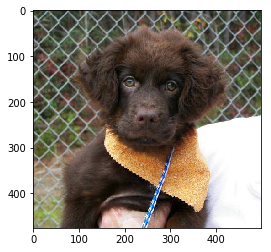

In [5]:
img = plt.imread(f'{PATH}valid/dogs/{files[6]}')
plt.imshow(img);

In [8]:
img.shape

(476, 499, 3)

In [9]:
img[:4,:4]

array([[[71, 73, 60],
        [70, 72, 59],
        [67, 67, 59],
        [63, 63, 55]],

       [[71, 73, 60],
        [70, 72, 59],
        [67, 69, 58],
        [65, 65, 57]],

       [[65, 69, 54],
        [64, 68, 53],
        [61, 65, 50],
        [61, 63, 50]],

       [[60, 68, 47],
        [59, 67, 46],
        [61, 65, 48],
        [61, 65, 50]]], dtype=uint8)

## Choosing a Learning Rate

First, create a new learner as we want to set the learning rate for a new (untrained) model.

In [10]:
# the architecture that we'll be using
arch = resnet34

sz = 224

In [11]:
# load data from path
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▋ | 311/360 [02:02<00:19,  2.54it/s, loss=0.465]

`learn` contains an attribute named `sched` which contains our learning rate scheduler, which has some plotting functionality to see effect of different learning rates.

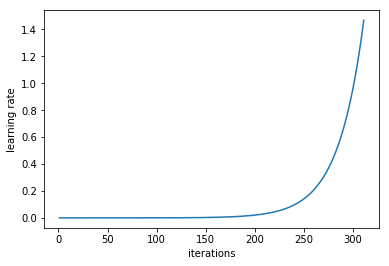

In [14]:
learn.sched.plot_lr()

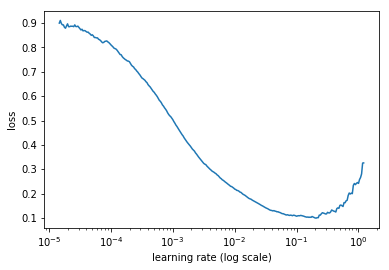

In [15]:
learn.sched.plot()

The loss is still improving at lr=1e-2 (0.01). So we'll use this learning rate. Note that the learning rate might change as we train the model, so we want to re-run this function from time to time.

## Our First Model: Quick Start

We will use a **resnet34** model that's pretrained on ImageNet dataset.

In [6]:
# the architecture that we'll be using
arch = resnet34

sz = 224

In [7]:
# load data from path
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [9]:
lr = 0.01
n_epochs = 3

learn.fit(lr, n_epochs)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.05057  0.02607  0.99072]                          
[ 1.       0.03682  0.02483  0.99121]                         
[ 2.       0.04261  0.02343  0.99268]                          



## Analyzing Results: Looking at Pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [22]:
# label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [23]:
data.classes

['cats', 'dogs']

In [25]:
# Predictions for validation set (log scale)
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [27]:
log_preds[:5]

array([[ -0.00013,  -8.91547],
       [ -0.00001, -11.76105],
       [ -0.     , -12.44498],
       [ -0.00087,  -7.04845],
       [ -0.00001, -11.85312]], dtype=float32)

In [35]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [56]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 5, replace=False)

In [38]:
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y) == is_correct)

In [49]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH + ds.fnames[idx]))

In [13]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [45]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [53]:
data.val_ds.fnames[1000]

'valid/dogs/dog.5430.jpg'

Correctly classified


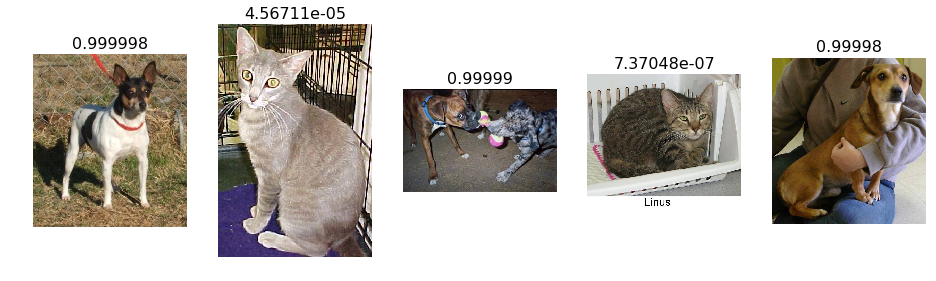

In [57]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


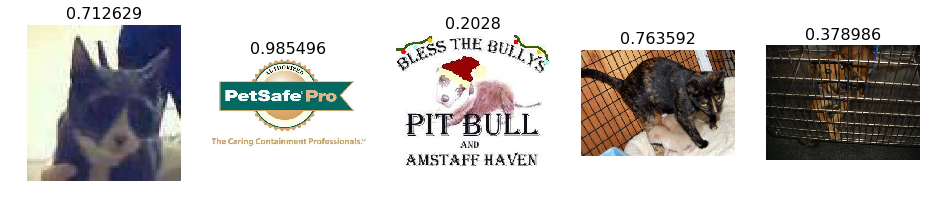

In [58]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [46]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [47]:
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


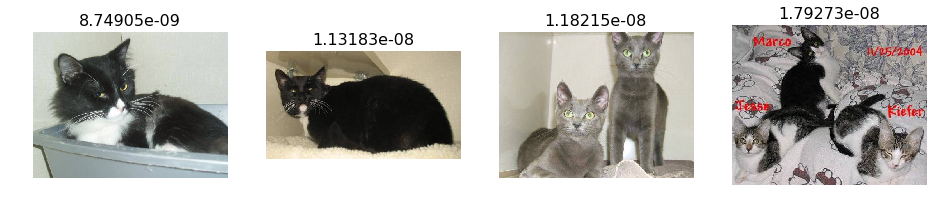

In [61]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


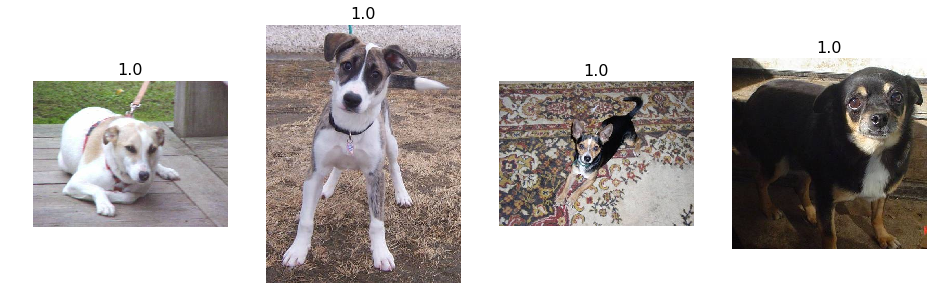

In [62]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


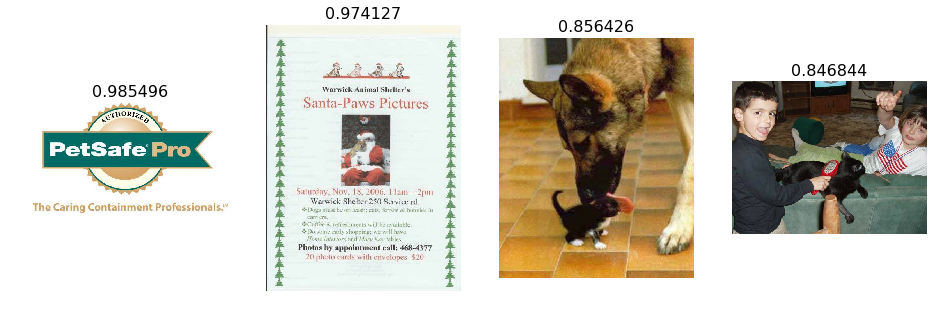

In [63]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


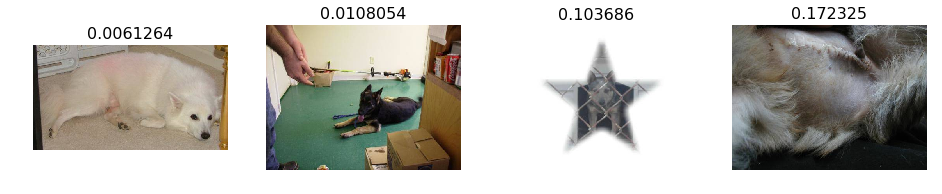

In [64]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


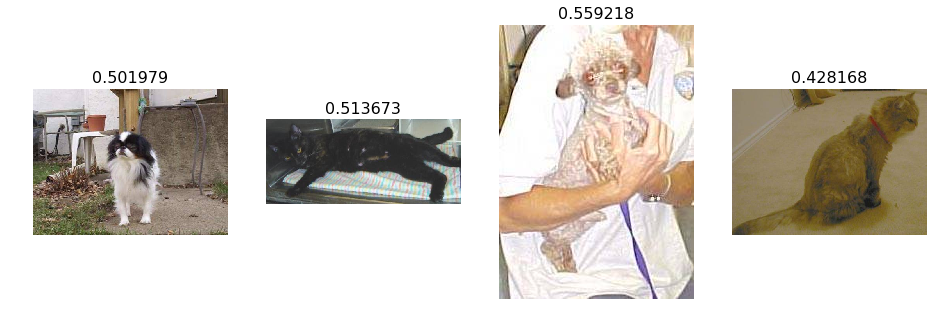

In [65]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

# Improving our Model

## Data Augmentation

In [10]:
# transforms
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [19]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [20]:
ims = np.stack([get_augs() for i in range(6)])

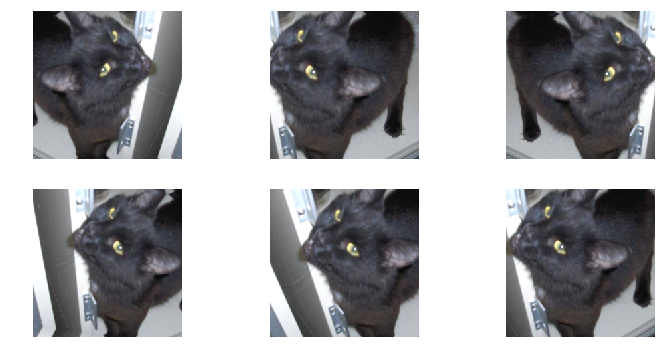

In [21]:
plots(ims, rows=2)

Now, let's create a new data object that includes these augmentation transforms.

In [22]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [23]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.0394   0.02715  0.99023]                          



In [24]:
learn.precompute=False

In [29]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.03495  0.02299  0.99072]                         
[ 1.       0.03423  0.02443  0.99072]                         
[ 2.       0.04405  0.02517  0.98975]                         



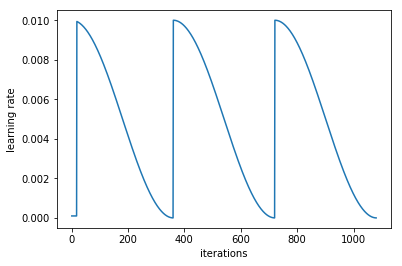

In [30]:
learn.sched.plot_lr()

In [27]:
learn.fit(1e-2, 3, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.       0.05007  0.02628  0.98926]                         
[ 1.       0.0315   0.02532  0.98926]                         
[ 2.       0.03731  0.02436  0.99072]                         
[ 3.       0.03332  0.02422  0.99121]                         
[ 4.       0.04835  0.02283  0.99072]                         
[ 5.       0.04308  0.02339  0.98877]                         



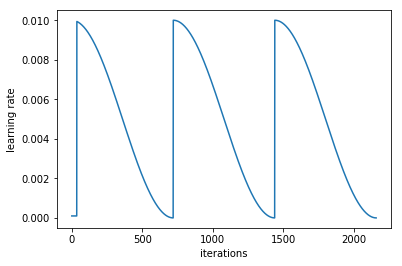

In [28]:
learn.sched.plot_lr()

In [31]:
learn.save('224_lastlayer')

In [32]:
learn.load('224_lastlayer')

## Fine-tunning and Differential learning rate annealing

In [33]:
learn.unfreeze()

In [34]:
lr=np.array([1e-4,1e-3,1e-2])

In [35]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.03807  0.02442  0.99121]                         
[ 1.       0.036    0.02121  0.99219]                         
[ 2.       0.0285   0.01878  0.99268]                         
[ 3.       0.03127  0.02121  0.99121]                         
[ 4.       0.02294  0.02022  0.99121]                         
[ 5.       0.01786  0.02353  0.99268]                         
[ 6.       0.01519  0.01877  0.99072]                         



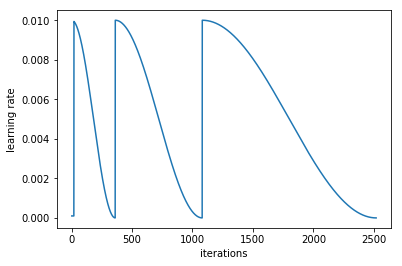

In [36]:
learn.sched.plot_lr()

In [37]:
learn.save('224_all')

In [38]:
learn.load('224_all')

## Test-time augmentation

In [39]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [40]:
accuracy(probs, y)

0.99199999999999999

## Analyzing Results

### Confusion Matrix

In [41]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[992   8]
 [  8 992]]


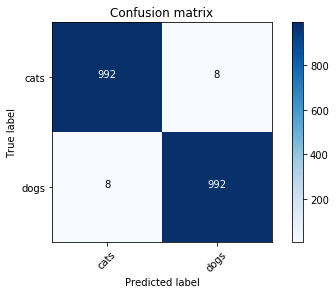

In [43]:
plot_confusion_matrix(cm, data.classes)

### Look at pictures

Most incorrect cats


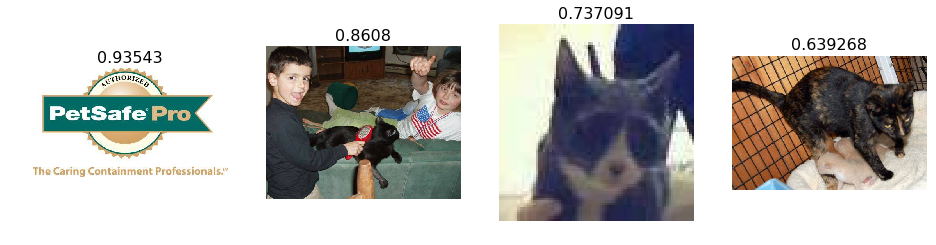

In [50]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


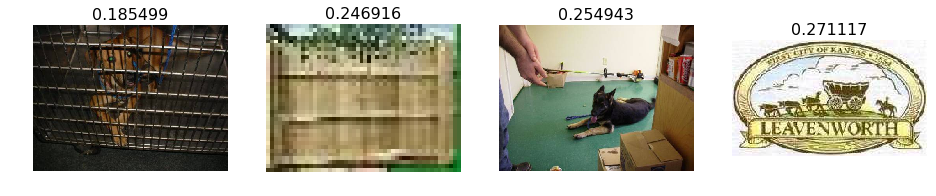

In [51]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")